In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
# import cv2
# from tqdm import tqdm_notebook as tqdm

In [2]:
files = os.listdir('./img_maps')

In [3]:
from keras.layers import (Conv2D, DepthwiseConv2D, MaxPool2D, BatchNormalization,
                          UpSampling2D, Activation, Input, Add, Conv2DTranspose)

from keras.models import Model, load_model

Using TensorFlow backend.


In [5]:
import mcubes 

In [ ]:
def inverted_residual(inp, expand, squeeze):
    
    x = Conv2D(expand, (1,1), padding='same', activation='relu')(inp)
    x = DepthwiseConv2D((3,3), padding='same', activation='relu')(x)
    x = Conv2D(squeeze, (1,1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    inp = Conv2D(squeeze, (1,1), padding='same', activation='relu')(inp)
    
    ans = Add()([inp, x])
    
    return ans

def deconv(inp, num_features):
    
    x = DepthwiseConv2D((3,3), padding='same', activation='relu')(inp)
    x = Conv2D(num_features, (1,1), padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    
    return x

inp = Input(shape=(None, None, 3))

# encoder

x = Conv2D(16, (3,3), padding='same', activation='relu')(inp)
x = inverted_residual(x, 32, 16)
x = MaxPool2D()(x)
x = inverted_residual(x, 64, 32)
x = MaxPool2D()(x)
x = inverted_residual(x, 128, 64)
x = MaxPool2D()(x)
x = inverted_residual(x, 256, 128)
x = MaxPool2D()(x)
x = inverted_residual(x, 512, 256)
x = MaxPool2D()(x)
x = inverted_residual(x, 1024, 512)

encoder_out = x

# decoder

x = deconv(encoder_out, 512)
x = deconv(x, 256)
x = deconv(x, 128)
x = deconv(x, 64)
x = deconv(x, 32)
x = Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)

decoder_out1 = x 

x = deconv(encoder_out, 512)
x = deconv(x, 256)
x = deconv(x, 128)
x = deconv(x, 64)
x = deconv(x, 32)
x = Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)

decoder_out2 = x 

model = Model(inputs=inp, outputs=[decoder_out1, decoder_out2])

In [ ]:
inp = Input(shape=(None, None, 3))

def residual(inp, num_features):
    
    x = Conv2D(num_features, (3,3), padding='same', activation='relu')(inp)
    x = Conv2D(num_features//2, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(num_features//2, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(num_features, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    if inp.shape[-1] != num_features: inp = Conv2D(num_features, (1,1), padding='same', activation='relu')(inp)
        
    ans = Add()([inp, x])
    return ans

def encoder(inp):
    
    x = Conv2D(16, (3,3), padding='same', activation='relu')(inp)
    x = residual(x, 32)
    x = MaxPool2D()(x)
    x = residual(x, 64)
    x = MaxPool2D()(x)
    x = residual(x, 128)
    x = MaxPool2D()(x)
    x = residual(x, 256)
    x = MaxPool2D()(x)
    x = residual(x, 512)
    x = MaxPool2D()(x)
    x = residual(x, 1024)
    
    return x

def decoder(inp):
    
    x = Conv2DTranspose(512, (3,3), padding='same', strides=(2,2), activation='relu')(inp)
    x = Conv2DTranspose(256, (3,3), padding='same', strides=(2,2), activation='relu')(x)
    x = Conv2DTranspose(128, (3,3), padding='same', strides=(2,2), activation='relu')(x)
    x = Conv2DTranspose(64, (3,3), padding='same', strides=(2,2), activation='relu')(x)
    x = Conv2DTranspose(32, (3,3), padding='same', strides=(2,2), activation='relu')(x)
    x = Conv2DTranspose(16, (3,3), padding='same', strides=(2,2), activation='relu')(x)
    x = Conv2D(1, (3,3), padding='same', strides=(2,2), activation='sigmoid')(x)
    
    return x

encoder_out = encoder(inp)
decoder_out1 = decoder(encoder_out)
decoder_out2 = decoder(encoder_out)

model = Model(inputs=inp, outputs = [decoder_out1, decoder_out2])

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [4]:
model = load_model('model_m5.h5')

In [ ]:
for fname in files[30:50]:
    images, fronts, backs = [], [], []
    each_1000 = np.load('./img_maps/'+fname)
    for each in each_1000:
        images.append(plt.imread(each[0])[66:,50:434]/255.)
        dual = np.load(each[1])/200.
        fronts.append(dual[:,:,1])
        backs.append(dual[:,:,0])
    images = np.array(images)
    fronts = np.expand_dims(np.array(fronts), 3)
    backs = np.expand_dims(np.array(backs), 3)
    
#     model.fit(images, [backs, fronts] , batch_size=2, epochs=5, validation_split=0.1)

In [ ]:
model.save('model_m9090909.h5')

In [ ]:
i= 76
# out = model.predict(np.expand_dims(cv2.resize(plt.imread('t.jpg')/255., (384, 384)),0))
out = model.predict(images[i:i+1])
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize = (20, 20))
# ax0.imshow(plt.imread('t.jpg'))
[ax.set_axis_off() for ax in (ax0, ax1, ax2, ax3, ax4)]
ax0.imshow(images[i])
ax1.imshow(backs[i,:,:,0])
ax2.imshow(fronts[i,:,:,0])
ax3.imshow(out[0][0,:,:,0])
ax4.imshow(out[1][0,:,:,0])

In [16]:
def dual_to_voxel(front, back):
    
    f, b = (front[0,:,:,0]*200).astype('i'), ((back[0,:,:,0])*200).astype('i')
    ma = int(np.max(back)*200)
    voxel = np.zeros((384, 384, 250))
    for i in range(384):
        for j in range(384):
            for k in range(f[i,j], ma - b[i,j]):
                voxel[i, j, k] = 1
#             if f[i, j]: voxel[i, j, f[i, j]] = 1
#             if b[i, j]: voxel[i, j, ma - b[i, j]] = 1
    return voxel

In [17]:
v = dual_to_voxel(out[0], out[1])

In [19]:
vertices, triangles = mcubes.marching_cubes(v, 0)
mcubes.export_mesh(vertices, triangles, "face.dae", "face")

In [ ]:
plt.imshow(np.sum(v,1)>0, cmap='gray')

In [ ]:
plt.imsave('face.png', out[1][0,:,:,0], cmap='gray')

In [ ]:
plt.imsave('face.png', images[i])
np.save('vox.npy', v)

In [86]:
from scipy.ndimage import median_filter

In [ ]:
f = median_filter(out[1][0,:,:,0], (5,5))
b = median_filter(out[0][0,:,:,0], (5,5))

In [ ]:
f, b = (f*200).astype('i'), (b*200).astype('i')
ma = int(np.max(b)*200) 
voxel = np.zeros((384, 384, 250))
for i in range(384):
    for j in range(384):
            for k in range(f[i,j], ma - b[i,j]):
                voxel[i, j, k] = 1
#         if f[i, j]: voxel[i, j, f[i, j]] = 1
#         if b[i, j]: voxel[i, j, ma - b[i, j]] = 1

In [ ]:
fronts.shape

In [12]:
each_1000 = np.load('./img_maps/'+files[46])
each = each_1000[100]
images, fronts, backs = [], [], []
images.append(plt.imread(each[0])[66:,50:434]/255.)
dual = np.load(each[1])/200.
fronts.append(dual[:,:,1])
backs.append(dual[:,:,0])
images = np.array(images)
fronts = np.expand_dims(np.array(fronts), 3)
backs = np.expand_dims(np.array(backs), 3)

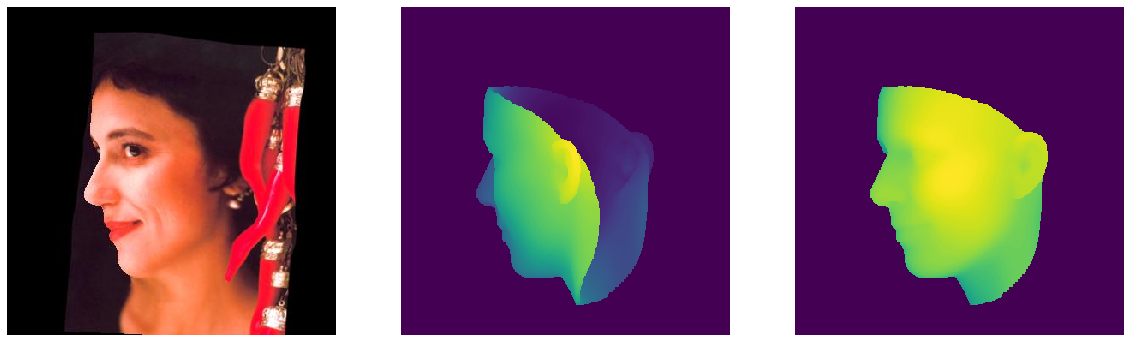

In [13]:
i = 0
# out = model.predict(images[i:i+1])
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (20, 20))
[ax.set_axis_off() for ax in (ax0, ax1, ax2)]
ax0.imshow(images[i])
ax1.imshow(backs[i,:,:,0])
ax2.imshow(fronts[i,:,:,0])

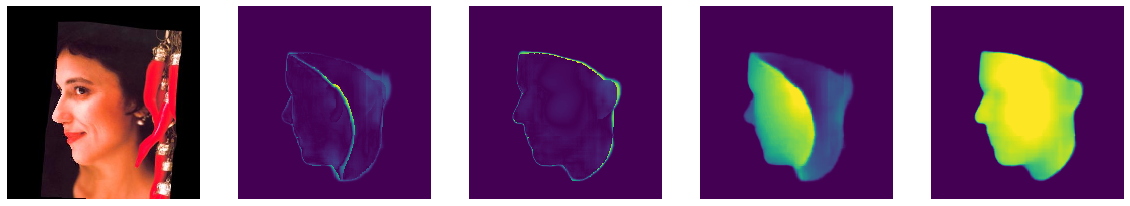

In [10]:
i = 0
out = model.predict(images[i:i+1])
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize = (20, 20))
[ax.set_axis_off() for ax in (ax0, ax1, ax2, ax3, ax4)]
ax0.imshow(images[i])
temp1 = np.abs(backs[i,:,:,0]-out[0][0,:,:,0])
# temp1[temp1==1] = 0
ax1.imshow(temp1 - np.min(temp1))
ax2.imshow(np.abs(fronts[i,:,:,0]-out[1][0,:,:,0]))
ax3.imshow(out[0][0,:,:,0])
ax4.imshow(out[1][0,:,:,0])

In [12]:
plt.imsave("img.png", images[0])
plt.imsave("depth.png", out[1][0,:,:,0])

In [ ]:
i = 0
img = np.expand_dims(cv2.resize(images[i], (192, 192)),0)

In [ ]:
%timeit model.predict(images[i:i+1])

In [ ]:
f_error, b_error = [], []
for fname in tqdm(files[50:60]):
    images, fronts, backs = [], [], []
    each_1000 = np.load('./img_maps/'+fname)
    for each in tqdm(each_1000):
        images.append(plt.imread(each[0])[66:,50:434]/255.)
        dual = np.load(each[1])/200.
        fronts.append(dual[:,:,1])
        backs.append(dual[:,:,0])
    images = np.array(images)
    fronts = np.array(fronts)
    backs = np.array(backs)
    
    out = model.predict(images)
        
    f_error.append(np.mean((out[1][:,:,:,0]-fronts)**2, 0))
    b_error.append(np.mean((out[0][:,:,:,0]-backs)**2, 0))

In [ ]:
np.mean(f_error)

In [ ]:
np.mean(b_error)

In [ ]:
img = np.expand_dims(cv2.resize(images[i], (192, 192)), 0)

In [ ]:
%timeit model.predict(img)

In [14]:
np.max(fronts[i,:,:,0])

1.055

In [15]:
f = fronts[i,:,:,0]*199
b = backs[i,:,:,0]*199

In [31]:
v = np.zeros((384,384,200))

In [32]:
for i in range(384):
    for j in range(384):
#         if f[i,j] <= 1 or b[i,j] <= 1: continue
#         for k in range(int(f[i,j]), int(199-b[i,j])+1):
#             v[i,j,k] = 1
        if b[i,j]>1: v[i,j,int(199- min(199,b[i,j]))] = 1
        if f[i,j]>1: v[i,j,min(199,int(f[i,j]))] = 1

In [33]:
np.save('v2.npy', v)

In [19]:
plt.imsave("img.png", images[0])

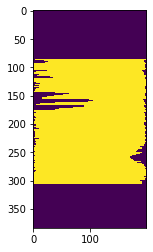

In [37]:
plt.imshow(np.sum(v,0)>0)

In [25]:
plt.imshow(median_filter(np.sum(v,1)>0,(3,3)))

NameError: name 'median_filter' is not defined

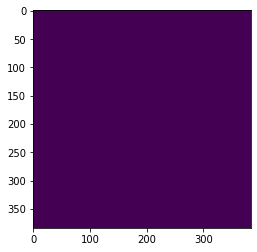

In [97]:
plt.imshow(median_filter(np.sum(v,2)>0,(3,3)))

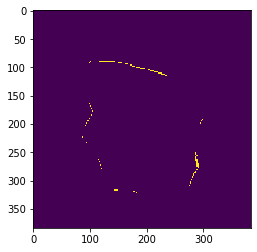

In [49]:
plt.imshow(v[:,:,-5])